# tfRecord

## Example data: uses train data from cifar-10 for demo

CIFAR-10: https://www.kaggle.com/c/cifar-10

In [1]:
import tensorflow as tf 
from sklearn import preprocessing
import pandas as pd 
import os 
import matplotlib.pyplot as plt 

In [2]:
data_path = 'cifar-10/'
imgs_list = os.listdir(data_path+'train')
label_df = pd.read_csv(data_path+'trainLabels.csv')

print('Number of images: {}'.format(len(imgs_list)))
print(label_df.head())

Number of images: 50000
   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile


In [3]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit((label_df['label'].unique()))
label_df['target'] = label_encoder.transform(label_df['label'].values)
print(label_df.head())

   id       label  target
0   1        frog       6
1   2       truck       9
2   3       truck       9
3   4        deer       4
4   5  automobile       1


## Conversion functions

In [4]:
def image_feature_png(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))

def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_example(image, label, target):
    feature = {
        "image": image_feature_png(image),
        "label": bytes_feature(label),
        "target": int64_feature(target),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [5]:
file_name = 'example.tfrec'

with tf.io.TFRecordWriter(file_name) as writer:
    for i in range(len(imgs_list)):
        img_path = data_path+'train/'+str(i+1)+".png"
        image = tf.io.decode_png(tf.io.read_file(img_path))
        example = create_example(image, label_df['label'].iloc[i],label_df['target'].iloc[i])
        writer.write(example.SerializeToString())

In [6]:
AUTO = tf.data.experimental.AUTOTUNE

def parse_tfrecord(example):
    ''' It is strange you need to use tf.string to read in an image '''
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    image = example['image']
    label = example['label']
    target = example['target']
    return (image,label,target)

def get_dataset(record_files):
    dataset = tf.data.TFRecordDataset(record_files, buffer_size=100)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [7]:
train_dataset = get_dataset("example.tfrec")
train_dataset = train_dataset.shuffle(10000).batch(1)

tf.Tensor([b'automobile'], shape=(1,), dtype=string) tf.Tensor([1], shape=(1,), dtype=int64)


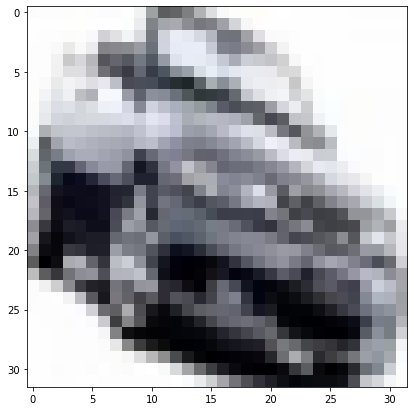

In [15]:
for sample in train_dataset.take(1):
    image, label, target = sample
    print(label, target)
    plt.figure(figsize=(7, 7))
    plt.imshow(image.numpy()[0,:,:,:])
    plt.show()